# **Covid 19 India Analysis and Forecasting**

### **Fetching Covid 19 - India Data set from Kaggel**

contains :
1. Covid 19 India cases
2. Testing details

Sources :Ministry of Health & Family Welfare ,  covid19india.org

In [418]:
import warnings
warnings.filterwarnings('ignore')

## loading dataset from kaggel
!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sudalairajkumar/covid19-in-india
import zipfile
zip_ref = zipfile.ZipFile('covid19-in-india.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

Saving kaggle.json to kaggle (2).json
covid19-in-india.zip: Skipping, found more recently modified local copy (use --force to force download)


In [419]:
## load data into pandas dataframe
import pandas as pd
covid_count_raw=pd.read_csv('/content/files/covid_19_india.csv')
testing_rate_raw=pd.read_csv('/content/files/StatewiseTestingDetails.csv')
testing_rate_raw.head()

,Date,State,TotalSamples,Negative,Positive
0,2020-04-17,Andaman and Nicobar Islands,1403.0,1210,12.0
1,2020-04-24,Andaman and Nicobar Islands,2679.0,NaN,27.0
2,2020-04-27,Andaman and Nicobar Islands,2848.0,NaN,33.0
3,2020-05-01,Andaman and Nicobar Islands,3754.0,NaN,33.0
4,2020-05-16,Andaman and Nicobar Islands,6677.0,NaN,33.0


In [420]:
covid_count_raw.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,30/01/20,6:00 PM,Kerala,1,0,0,0,1
1,2,31/01/20,6:00 PM,Kerala,1,0,0,0,1
2,3,01/02/20,6:00 PM,Kerala,2,0,0,0,2
3,4,02/02/20,6:00 PM,Kerala,3,0,0,0,3
4,5,03/02/20,6:00 PM,Kerala,3,0,0,0,3


In [421]:
## keep original copy 
covid_counts = covid_count_raw.copy(deep = False)
testing_rates = testing_rate_raw.copy(deep = False)

### **Fetching India Statewise Population information from statisticstimes.com**

Source: Population of india as per the 2019 Unique Identification Authority (UIA) of India Survey

In [422]:
## install libraries
!pip install html-table-parser-python3
import urllib.request
from pprint import pprint
from html_table_parser import HTMLTableParser

def url_get_contents(url):

    # Opens a website and read it
    #making request to the website
    req = urllib.request.Request(url=url)
    f = urllib.request.urlopen(req)

    #reading contents of the website
    return f.read()


In [423]:
#making request to the website
req = urllib.request.Request('http://statisticstimes.com/demographics/india/indian-states-population.php')
f = urllib.request.urlopen(req)
#reading contents of the website
xhtml = f.read().decode('utf-8') 

p = HTMLTableParser() 
p.feed(xhtml) 
pprint(p.tables[1]) 
  
# converting the parsed data to 
# datframe 
population_counts_raw = pd.DataFrame(p.tables[1])


[['Rank',
  'State/UT',
  'Population',
  'Growth (2019-2011)',
  'Share (%)',
  'Country',
  'W rank'],
 ['2019', '2011', 'Absolute', '%', '2019'],
 ['NCT',
  'Delhi',
  '18,710,922',
  '16,787,941',
  '1,922,981',
  '11.45',
  '1.36',
  'Malawi',
  '63'],
 ['18',
  'Haryana',
  '28,204,692',
  '25,351,462',
  '2,853,230',
  '11.25',
  '2.06',
  'Venezuela',
  '51'],
 ['14',
  'Kerala',
  '35,699,443',
  '33,406,061',
  '2,293,382',
  '6.87',
  '2.60',
  'Morocco',
  '41'],
 ['20',
  'Himachal Pradesh',
  '7,451,955',
  '6,864,602',
  '587,353',
  '8.56',
  '0.54',
  'China, Hong Kong SAR',
  '104'],
 ['16',
  'Punjab',
  '30,141,373',
  '27,743,338',
  '2,398,035',
  '8.64',
  '2.20',
  'Mozambique',
  '48'],
 ['12',
  'Telangana',
  '39,362,732',
  '35,004,000',
  '4,358,732',
  '12.45',
  '2.87',
  'Iraq',
  '36'],
 ['25',
  'Goa',
  '1,586,250',
  '1,458,545',
  '127,705',
  '8.76',
  '0.12',
  'Bahrain',
  '153'],
 ['19',
  'Uttarakhand',
  '11,250,858',
  '10,086,292',
  '1,164,

In [424]:
#keep original copy
population_counts = population_counts_raw.copy(deep = False)
population_counts.head()

,0,1,2,3,4,5,6,7,8
0,Rank,State/UT,Population,Growth (2019-2011),Share (%),Country,W rank,None,None
1,2019,2011,Absolute,%,2019,None,None,None,None
2,NCT,Delhi,"18,710,922","16,787,941","1,922,981",11.45,1.36,Malawi,63
3,18,Haryana,"28,204,692","25,351,462","2,853,230",11.25,2.06,Venezuela,51
4,14,Kerala,"35,699,443","33,406,061","2,293,382",6.87,2.60,Morocco,41


In [425]:
# selecting the required columns: State and Population as of 2019
population = population_counts[[1,2]].drop([0,1],axis = 0)
population.columns = ['State','Population']
population.head()

,State,Population
2,Delhi,"18,710,922"
3,Haryana,"28,204,692"
4,Kerala,"35,699,443"
5,Himachal Pradesh,"7,451,955"
6,Punjab,"30,141,373"


### **Data Standardization**
Aim is to standardize the data, check for data quality and transform it in a easier-to-use format for further analysis and modeling


In [426]:
# standardize date format
covid_counts['Date'] = pd.to_datetime(covid_counts['Date'],format='%d/%m/%y')
testing_rates['Date'] = pd.to_datetime(testing_rates['Date'],format='%Y-%m-%d')


In [427]:
# merging the dataframes
# check for merge key discrepencies 
population_states = population['State'].unique()
population_states.sort()
population_states = population_states.tolist()

covid_counts_states = covid_counts['State/UnionTerritory'].unique()
covid_counts_states.sort()
covid_counts_states = covid_counts_states.tolist()

testing_rates_states = testing_rates['State'].unique()
testing_rates_states.sort()
testing_rates_states = testing_rates_states.tolist()
from itertools import zip_longest 
check_mergekey = pd.DataFrame(list(zip_longest(population_states,covid_counts_states,testing_rates_states)),columns = ['Population_df','Covid_df','Tetsing_df'])
check_mergekey

,Population_df,Covid_df,Tetsing_df
0,A.& N.Islands,Andaman and Nicobar Islands,Andaman and Nicobar Islands
1,Andhra Pradesh,Andhra Pradesh,Andhra Pradesh
2,Arunachal Pradesh,Arunachal Pradesh,Arunachal Pradesh
3,Assam,Assam,Assam
4,Bihar,Bihar,Bihar
5,Chandigarh,Cases being reassigned to states,Chandigarh
6,Chhattisgarh,Chandigarh,Chhattisgarh
7,Dadra & Nagar Haveli and Daman & Diu,Chandigarh***,Dadra and Nagar Haveli and Daman and Diu
8,Delhi,Chhattisgarh,Delhi
9,Goa,Dadar Nagar Haveli,Goa


We can see there are quite a **lot of mismatches in the State/Union Territory names**, especially in the covid_counts dataframe. Hence we need to clean the names.

In [428]:
# column renaming
covid_counts.rename(columns = {'State/UnionTerritory':'State'},inplace = True)

#### Data cleanup
# remove inconsitencies in state names present in the covid_count dataframe
# 1. trailing characters '***'
covid_counts['State'] = covid_counts['State'].str.replace('\*\*\*','')


# 2. drop 'Cases being reassigned to states'
covid_counts.query("State != 'Cases being reassigned to states'", inplace = True)


# 3. Inconsitent naming of state 'Telangana'
covid_counts['State'] = covid_counts['State'].str.replace('Telengana','Telangana')


# 4. Include 'Dadar Nagar Haveli'	and 'Daman and Diu' under 'Dadra and Nagar Haveli and Daman and Diu' 
import numpy as np
covid_counts['State'] = np.where(covid_counts['State'] == 'Dadar Nagar Haveli','Dadra and Nagar Haveli and Daman and Diu',covid_counts['State'])
covid_counts['State'] = np.where(covid_counts['State'] == 'Daman and Diu','Dadra and Nagar Haveli and Daman and Diu',covid_counts['State'])

# 5. replace special character '&' with 'and'
covid_counts['State'] = covid_counts['State'].str.replace('&','and')
population['State'] = population['State'].str.replace('&','and')
testing_rates['State'] = testing_rates['State'].str.replace('&','and')

# 6. standerdise Union territory name
population['State'] = population['State'].str.replace('A.and N.Islands','Andaman and Nicobar Islands')



In [429]:
# de-dup data
testing_rates.drop_duplicates(keep=False,inplace=True) 
covid_counts.drop_duplicates(keep=False,inplace=True) 

# check for duplicates at date - state level
print("duplicate values in covid counts:",covid_counts[covid_counts[['Date','State']].duplicated()].shape[0])
print("duplicate values in testing counts:",testing_rates[testing_rates[['Date','State']].duplicated()].shape[0])

duplicate values in covid counts: 0
duplicate values in testing counts: 0


As there are **duplicates present** at the Date - State level in the covid counts dataframe, hence we would need to aggragate the counts on Date and State before mereging the datasets 

In [430]:
covid_counts = covid_counts.groupby(['Date','State'])['Cured',	'Deaths',	'Confirmed'].sum().reset_index()
# re-check for duplicates at date - state level
print("re-checking duplicate values in covid counts:",covid_counts[covid_counts[['Date','State']].duplicated()].shape[0])


re-checking duplicate values in covid counts: 0


In [431]:
# remove ',' in population column so that the value can be converted to int 
population['Population'] = population['Population'].str.replace(',','')

Great! we can now collate all the counts in **one dataframe**.

In [432]:
# merge data sets
merge_1 = covid_counts.merge(population, left_on='State', right_on='State')[['State','Date','Cured','Deaths','Confirmed'	,'Population'	]]
state_wise_counts = merge_1.merge(testing_rates[['State','Date','TotalSamples']], on =['State','Date'], how = 'left')
state_wise_counts

,State,Date,Cured,Deaths,Confirmed,Population,TotalSamples
0,Kerala,2020-01-30,0,0,1,35699443,NaN
1,Kerala,2020-01-31,0,0,1,35699443,NaN
2,Kerala,2020-02-01,0,0,2,35699443,NaN
3,Kerala,2020-02-02,0,0,3,35699443,NaN
4,Kerala,2020-02-03,0,0,3,35699443,NaN
...,...,...,...,...,...,...,...
9222,Sikkim,2020-12-05,4677,112,5147,690251,63780.0
9223,Sikkim,2020-12-06,4686,115,5168,690251,63986.0
9224,Sikkim,2020-12-07,4695,115,5197,690251,64029.0
9225,Sikkim,2020-12-08,4715,117,5203,690251,64280.0


In [433]:
## check for null values
null_state_count = state_wise_counts['State'].isnull().sum()
null_date_count = state_wise_counts['Date'].isnull().sum()
null_cured_count = state_wise_counts['Cured'].isnull().sum()
null_deaths_count = state_wise_counts['Deaths'].isnull().sum()
null_confired_count = state_wise_counts['Confirmed'].isnull().sum()
null_Population_count = state_wise_counts['Population'].isnull().sum()
null_totalTestingsamples_count = state_wise_counts['TotalSamples'].isnull().sum()

print("null_state_count:",null_state_count,"\n")
print("null_date_count:",null_date_count,"\n")
print("null_cured_count:",null_cured_count,"\n")
print("null_deaths_count:",null_deaths_count,"\n")
print("null_confired_count:",null_confired_count,"\n")
print("null_totalTestingsamples_count:",null_Population_count,"\n")
print("null_totalTestingsamples_count:",null_totalTestingsamples_count,"\n")

null_state_count: 0 

null_date_count: 0 

null_cured_count: 0 

null_deaths_count: 0 

null_confired_count: 0 

null_totalTestingsamples_count: 0 

null_totalTestingsamples_count: 1236 



This is quite expected, we can handle the testing sample NULL values by replacing them with 0

In [434]:
# replace NaN with 0
state_wise_counts.fillna(0)

,State,Date,Cured,Deaths,Confirmed,Population,TotalSamples
0,Kerala,2020-01-30,0,0,1,35699443,0.0
1,Kerala,2020-01-31,0,0,1,35699443,0.0
2,Kerala,2020-02-01,0,0,2,35699443,0.0
3,Kerala,2020-02-02,0,0,3,35699443,0.0
4,Kerala,2020-02-03,0,0,3,35699443,0.0
...,...,...,...,...,...,...,...
9222,Sikkim,2020-12-05,4677,112,5147,690251,63780.0
9223,Sikkim,2020-12-06,4686,115,5168,690251,63986.0
9224,Sikkim,2020-12-07,4695,115,5197,690251,64029.0
9225,Sikkim,2020-12-08,4715,117,5203,690251,64280.0


In [435]:
# aggragate values on country level
# covid metrics
covid_counts_india = covid_counts.groupby(['Date'])['Cured',	'Deaths',	'Confirmed'].sum().reset_index()
covid_counts_india

,Date,Cured,Deaths,Confirmed
0,2020-01-30,0,0,1
1,2020-01-31,0,0,1
2,2020-02-01,0,0,2
3,2020-02-02,0,0,3
4,2020-02-03,0,0,3
...,...,...,...,...
310,2020-12-05,9058822,139700,9608211
311,2020-12-06,9100792,140182,9644222
312,2020-12-07,9139901,140573,9677203
313,2020-12-08,9178946,140958,9703770


In [436]:
# pick up latest country level testing counts
latest_testingcounts_india = testing_rates[testing_rates['Date']==testing_rates['Date'].max()].groupby(['Date'])['TotalSamples'].sum().reset_index()


### **Exploratory Data Analysis**
Analyzing the trends country wide and state wise:
1. Covid cases vs time
2. Testing vs Population
2. Visualizing the cases state wise

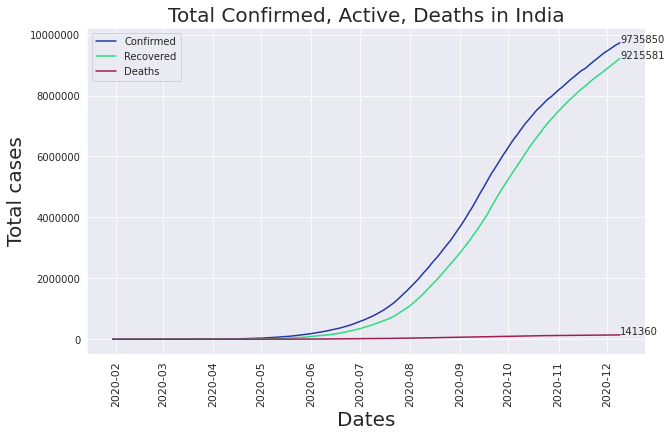

In [437]:
## plot covid cases in India
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
#palette = sns.color_palette("mako_r", 6)

#fig, ax = plt.subplots(2,2, figsize = (25,8))
fig = plt.figure(figsize = (10,6))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Total Confirmed, Active, Deaths in India" , fontsize = 20)

ax1 = sns.lineplot(y= covid_counts_india['Confirmed'],x= covid_counts_india['Date'],label = 'Confirmed',color = '#2338A5')
ax2 = sns.lineplot(y= covid_counts_india['Cured'],x= covid_counts_india['Date'],label = 'Recovered',color = '#2BDC82')
ax3 = sns.lineplot(y= covid_counts_india['Deaths'],x= covid_counts_india['Date'],label = 'Deaths',color = '#9F1C55')

ax1.ticklabel_format(useOffset=False, style='plain', axis='y')

def datalables(column_name):
  lst = covid_counts_india[covid_counts_india['Date'] == covid_counts_india['Date'].max()][column_name].to_list()
  y = int(lst[0])
  x = covid_counts_india['Date'].max()
  plt.text(x = x, y = y,s = '{:.0f}'.format(y))

datalables('Confirmed')
datalables('Cured')
datalables('Deaths')

#sns.lineplot(data =covid_counts_india, x = "Date", y = "Confirmed" ,ax = ax[0][0])


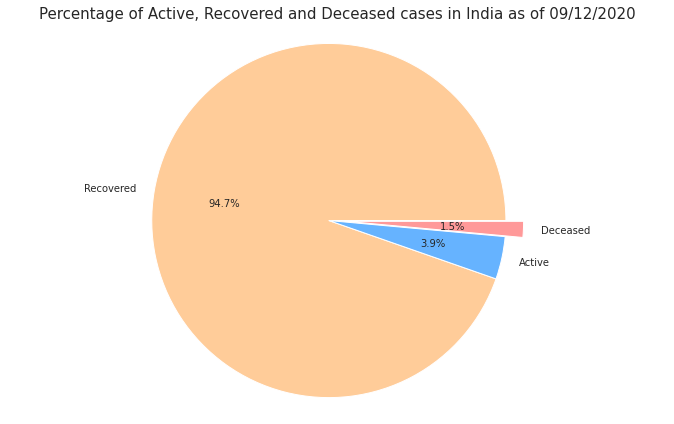

In [438]:
# percentage of active , recovered , deceased cases
labels = ['Recovered','Active','Deceased']
## as the counts are cumulative, hence selecting the latest counts
confirmed_counts = covid_counts_india[covid_counts_india['Date'] == covid_counts_india['Date'].max()]['Confirmed'].to_list()
recovered_counts = covid_counts_india[covid_counts_india['Date'] == covid_counts_india['Date'].max()]['Cured'].to_list()
deceased_counts = covid_counts_india[covid_counts_india['Date'] == covid_counts_india['Date'].max()]['Deaths'].to_list()

active_counts = int(confirmed_counts[0]) - (int(recovered_counts[0]) + int(deceased_counts[0]) )
sizes = []
sizes.append(recovered_counts[0])
sizes.append(active_counts)
sizes.append(deceased_counts[0])

explode = (0, 0,0.1)
colors =['#ffcc99','#66b3ff','#ff9999']

plt.figure(figsize= (10,6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%')

plt.title('Percentage of Active, Recovered and Deceased cases in India as of {}'.format(covid_counts_india['Date'].max().strftime('%d/%m/%Y')),fontsize = 15)
plt.axis('equal')
plt.tight_layout()

From the above chart we can see that the Covid 19 mortality rate in India is **lesser than the world average** of 3% 

source: https://www.worldometers.info/coronavirus/

In [439]:
india_population = population[population['State']=='India']['Population'].to_list()
testing_counts_india = latest_testingcounts_india['TotalSamples'].to_list()

Testing_rate = testing_counts_india[0]/float(india_population[0])
positivity_rate = int(confirmed_counts[0])/testing_counts_india[0]

#print(round(Testing_rate*100,2))
#print(round(positivity_rate*100,2))


class color:
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   BOLD = '\033[1m'
   END = '\033[0m'

print(color.BOLD + 'Testing rate in India (per 100) :'+ color.DARKCYAN + ' {}'.format(round(Testing_rate*100,2)) + color.END )
print(color.BOLD + 'Covid Positivity rate in India (per 100 test samples) :'+ color.BLUE + ' {}'.format(round(positivity_rate*100,2)) + color.END )

Testing rate in India (per 100) : 11.62
Covid Positivity rate in India (per 100 test samples) : 6.11


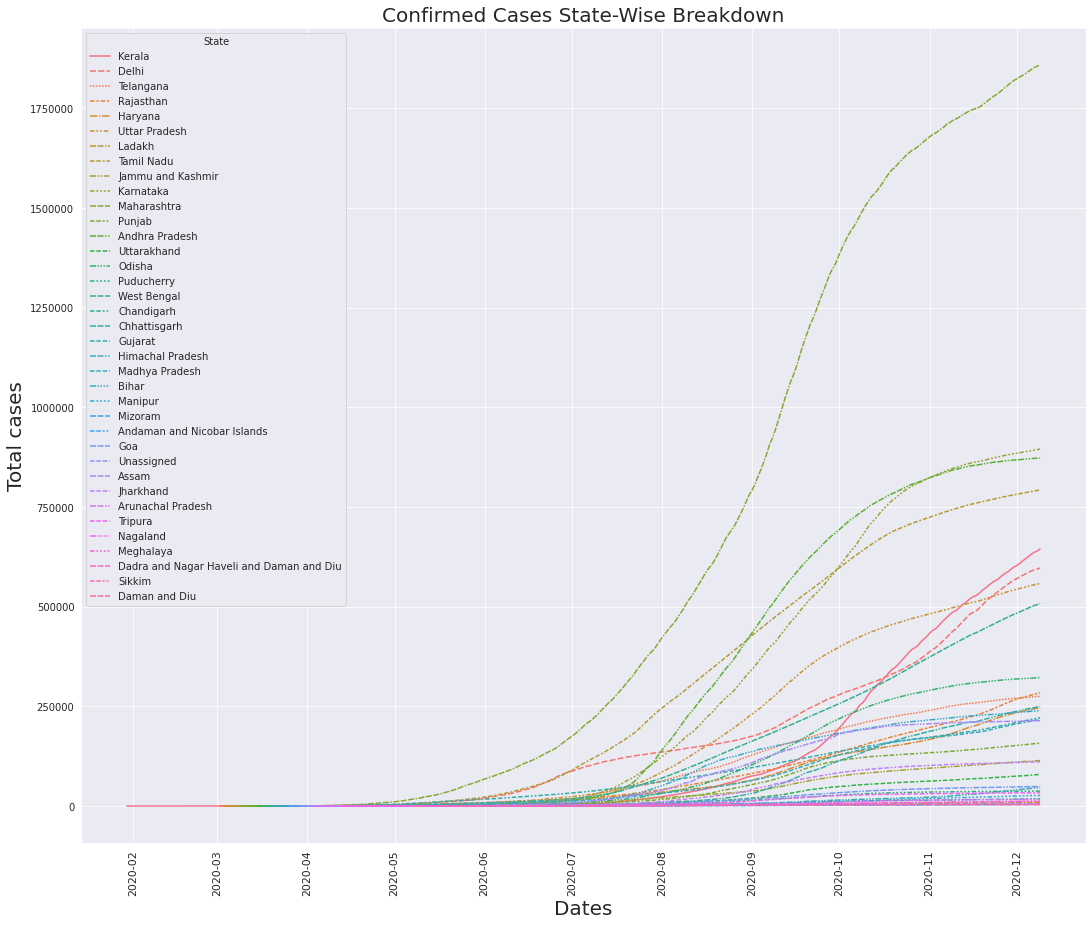

In [440]:
## state wise breakdown of confirmed cases
sns.set_style("darkgrid")

fig = plt.figure(figsize = (18,15))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Confirmed Cases State-Wise Breakdown" , fontsize = 20)

ax = sns.lineplot(data = covid_counts, y= 'Confirmed',x= 'Date',hue = 'State',style ='State')
ax.ticklabel_format(useOffset=False, style='plain', axis='y')


In [441]:
# statewise insight
state_wise_counts['Population'] = state_wise_counts['Population'].astype(int)
state_wise_counts['TotalSamples'] = state_wise_counts['TotalSamples'].fillna(0).astype(int)
state_wise_counts['TotalConfirmed'] = state_wise_counts['Confirmed'].fillna(0).astype(int)
state_cases = state_wise_counts[state_wise_counts['State']!='Unassigned'].groupby('State')['Population','TotalConfirmed','Deaths','Cured','TotalSamples'].max().reset_index()

state_cases['Active cases'] = state_cases['TotalConfirmed'] - (state_cases['Deaths']+state_cases['Cured'])
state_cases["Confirmed(per 100)"] = round(100*state_cases["TotalConfirmed"]/state_cases["Population"],2)
state_cases["Testing rate(per 100)"] = round(100*state_cases["TotalSamples"]/state_cases["Population"],2)
state_cases["Death Rate(per 100)"] = round(100*state_cases["Deaths"]/state_cases["TotalConfirmed"],2)

state_cases.sort_values('TotalConfirmed', ascending= False).style.background_gradient(cmap='Reds',subset=["TotalConfirmed","Deaths","Active cases","Confirmed(per 100)","Death Rate(per 100)"])\
.background_gradient(cmap='Blues',subset=["Population","Cured","TotalSamples","Testing rate(per 100)"])

 

,State,Population,TotalConfirmed,Deaths,Cured,TotalSamples,Active cases,Confirmed(per 100),Testing rate(per 100),Death Rate(per 100)
19,Maharashtra,123144223,1859367,47827,1737080,11377074,74460,1.510000,9.240000,2.570000
15,Karnataka,67562686,895284,11880,858370,11878413,25034,1.330000,17.580000,1.330000
1,Andhra Pradesh,53903393,872839,7042,860368,10509805,5429,1.620000,19.500000,0.810000
29,Tamil Nadu,77841267,792788,11822,770378,12605289,10588,1.020000,16.190000,1.490000
16,Kerala,35699443,644696,2472,582351,6702885,59873,1.810000,18.780000,0.380000
8,Delhi,18710922,597112,9763,565039,6869328,22310,3.190000,36.710000,1.640000
32,Uttar Pradesh,237882725,558173,7967,528832,20621452,21374,0.230000,8.670000,1.430000
34,West Bengal,99609303,507995,8820,475425,6211537,23750,0.510000,6.240000,1.740000
24,Odisha,46356334,321913,1784,316970,6214174,3159,0.690000,13.410000,0.550000
27,Rajasthan,81032689,284116,2468,260773,4664755,20875,0.350000,5.760000,0.870000


Couple of intersting observations from the above heat map:
1. **Delhi** has the highest Confirmed cases per population of 100, which can be attributed to high testing rates. Hence the significantly lower death rate in comparision.
2. **Maharastra** has both the highest number of total Confirmed cases, though the death rate and cases confirmed per 100 is relatively lower.
3. **Punjab** has the highest death rate, but a significanlty low testing rate and total confirmed cases.
4. The most populous state in the country, **Uttar Pradesh** is quite lacking in testing covid cases.


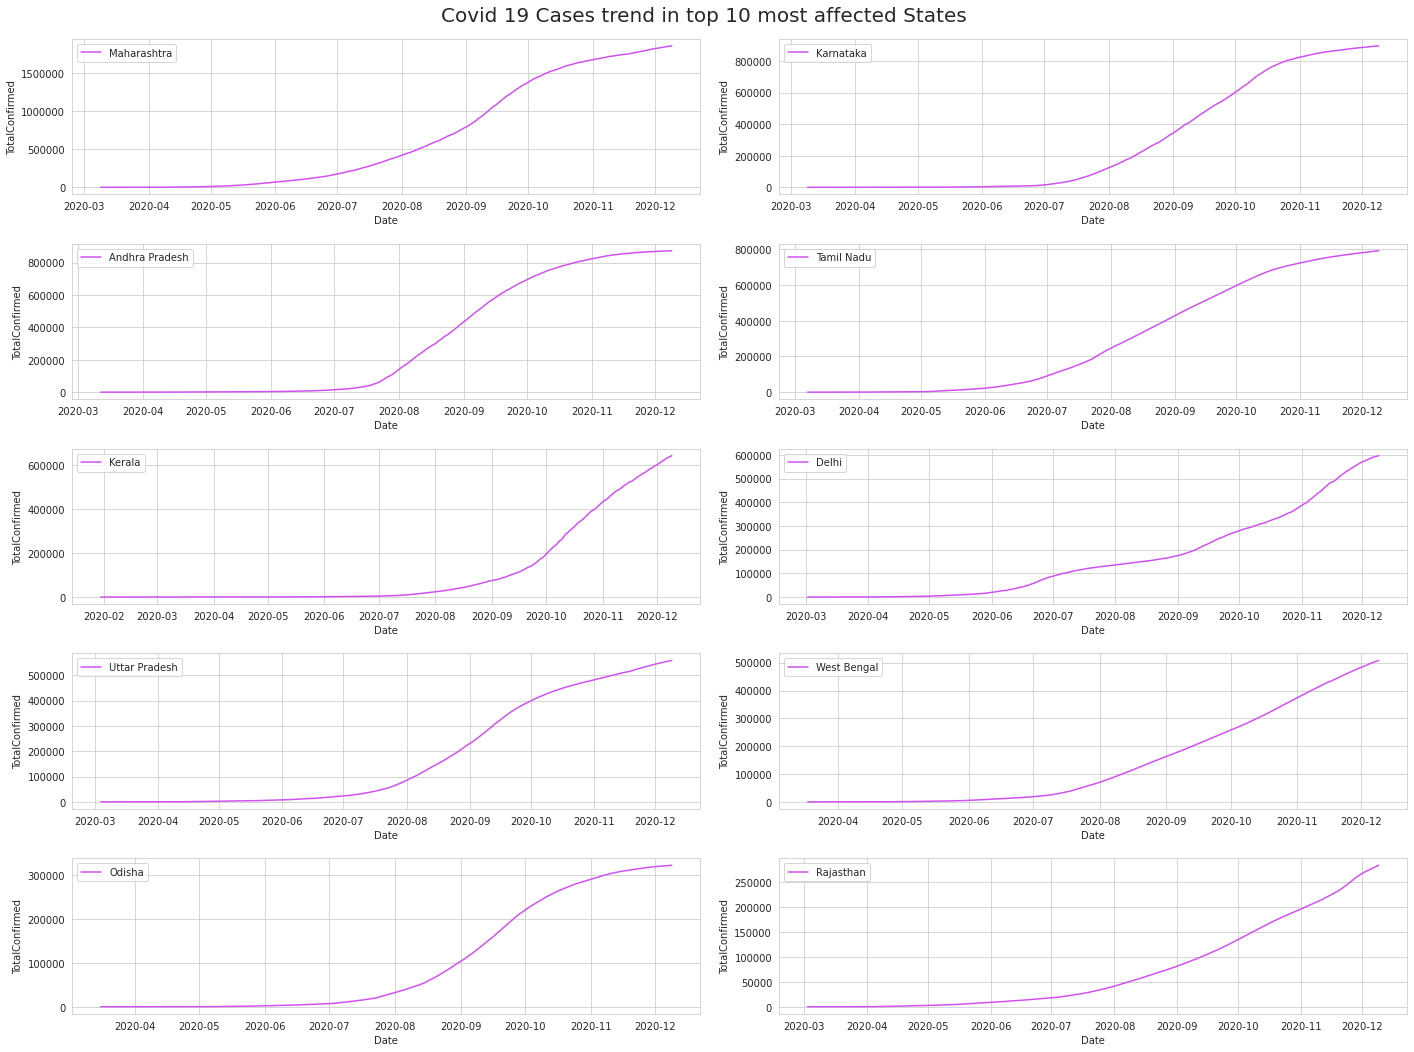

In [442]:
# visualizing trends in top 10 most severly affacted states

sns.set_style("whitegrid")
#palette = sns.color_palette("mako_r", 6)
# fetch timeseries counts for top 10 states
state_cases_sorted = state_cases.sort_values('TotalConfirmed', ascending= False)
state_cases_top9 = state_cases_sorted.iloc[:10]
#mask = (state_wise_counts['Date'] > '2020-10-01') & (state_wise_counts['Date'] <= '2020-12-31')
#state_top9_timeseries_data = state_wise_counts.loc[mask].merge(state_cases_top9[['State']], how = 'inner', on = 'State')
state_top9_timeseries_data = state_wise_counts.merge(state_cases_top9[['State']], how = 'inner', on = 'State')


state_cases_top9_list = state_cases_sorted.iloc[:10]['State'].to_list()
k = 0
fig, axes = plt.subplots(5, 2, figsize = (20,15))
for i in range (0,5):
  for j in range (0,2):
    state = state_cases_top9_list[k]
    ax1.ticklabel_format(useOffset=False, style='plain', axis='y')
    ax1 = sns.lineplot(ax = axes[i,j],data = state_top9_timeseries_data[state_top9_timeseries_data['State']== state], y= 'TotalConfirmed',x= 'Date',label = state, color = '#d050f0' ,markers = True,dashes=False)    
    
    k = k + 1
plt.tight_layout(pad=2.0)
plt.suptitle("Covid 19 Cases trend in top 10 most affected States " , fontsize = 20)
fig.subplots_adjust(top=0.95)

We can see that even though the confirmed cases rate is plateauing for some states, states like **Rajasthan and West Bengal** show a steep increase in the rate of confirmed cases.

# **Forecasting Trends**

Using Random Forest Regressor

In [443]:
# decode the data 
covid_counts_india['Month'] = covid_counts_india['Date'].dt.month
covid_counts_india['Day'] = covid_counts_india['Date'].dt.day
covid_counts_india['Year'] = covid_counts_india['Date'].dt.year
X = covid_counts_india[['Month',	'Day',	'Year']]
Y  = covid_counts_india['Confirmed']

In [444]:
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestRegressor as regr
from sklearn.metrics import r2_score
X_train,X_test,Y_train,Y_test = tts(X,Y,test_size =0.1,random_state =None)
model = regr()
model.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [445]:
#check model performance on test data
Yhat = model.predict(X_test)
r2_score_rdr = r2_score(Yhat,Y_test)
r2_score_rdr

0.9998912069848582

In [446]:
# create future dates for prediction 
import datetime
future_dates =[]
start_date = covid_counts_india['Date'].max()

for i in range(0,15):
  date = start_date + datetime.timedelta(days=1)
  future_dates.append(date)
  start_date = date

test = pd.DataFrame(future_dates,columns =['Date'])
Prediction_df = pd.concat([covid_counts_india[['Date']],test[['Date']]])
Prediction_df['Month'] = Prediction_df['Date'].dt.month
Prediction_df['Day'] = Prediction_df['Date'].dt.day
Prediction_df['Year'] = Prediction_df['Date'].dt.year
X_pred  = Prediction_df[['Month','Day','Year']]


In [447]:
# predict values
Y_pred = model.predict(X_pred)
Y_pred = np.round(Y_pred).astype(int)
Prediction_df['RFR_Confirmed'] = Y_pred
Prediction_df.head()

,Date,Month,Day,Year,RFR_Confirmed
0,2020-01-30,1,30,2020,115
1,2020-01-31,1,31,2020,194
2,2020-02-01,2,1,2020,2
3,2020-02-02,2,2,2020,2
4,2020-02-03,2,3,2020,3


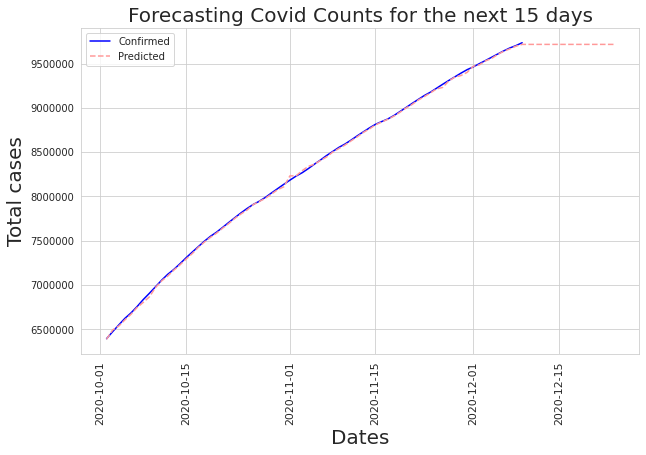

In [448]:
#plot prediction
fig = plt.figure(figsize = (10,6))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Forecasting Covid Counts for the next 15 days" , fontsize = 20)

mask_1 = (covid_counts_india['Date'] > '2020-10-01') & (covid_counts_india['Date'] <= '2021-12-31')
mask_2 = (Prediction_df['Date'] > '2020-10-01') & (Prediction_df['Date'] <= '2021-12-31')

#plt.ylim(bottom=6000000.,)
ax1 = sns.lineplot( data = covid_counts_india.loc[mask_1], y= 'Confirmed',x= 'Date',label = 'Confirmed',color = 'blue' )

ax1 = sns.lineplot(data = Prediction_df.loc[mask_2] , y = 'RFR_Confirmed' , x = 'Date',linestyle ='dashed',color = '#ff9999',label = 'Predicted')

ax1.ticklabel_format(useOffset=False, style='plain', axis='y')

As per the predicted values, the trend seems to be **flattening of the curve** in the next few days.
 

Scope for improvement:
1. Training the model on multi country data, to avoid overfitting 
